<a href="https://colab.research.google.com/github/KorotkovED/Diplom/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Diplom_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДИПЛОМ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Часть 1

### Изучение исходных данных и предметной области. Отбор признаков запросов, которые можно использовать при решении задачи и обоснование данного выбора.

In [ ]:
pip install pandas


In [ ]:
pip install retentioneering

In [ ]:
pip install user_agents

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
import time
from user_agents import parse


**Загрузка данных из database.csv в перемнную data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/database.csv", delimiter=';', on_bad_lines='skip')



<ipython-input-93-fae6f692e514>:1: DtypeWarning:

Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256373 entries, 0 to 2256372
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   body_bytes_sent  int64  
 1   http_referer     object 
 2   http_user_agent  object 
 3   remote_addr      object 
 4   request_method   object 
 5   request_path     object 
 6   request_proto    object 
 7   request_time     float64
 8   status           int64  
 9   time_local       object 
dtypes: float64(1), int64(2), object(7)
memory usage: 172.1+ MB


**Загружаем в новую переменную отфильтрованные данные, где 'http_user_agent' и 'request_path' не NaN, т.к. эти данные пригодны для дальнейшего анализа.

In [ ]:
df = data[~data[['http_user_agent','request_path']].isna().any(axis=1)].reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200764 entries, 0 to 200763
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   body_bytes_sent  200764 non-null  int64  
 1   http_referer     137798 non-null  object 
 2   http_user_agent  200764 non-null  object 
 3   remote_addr      200764 non-null  object 
 4   request_method   200764 non-null  object 
 5   request_path     200764 non-null  object 
 6   request_proto    200764 non-null  object 
 7   request_time     200764 non-null  float64
 8   status           200764 non-null  int64  
 9   time_local       200764 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 15.3+ MB


In [ ]:
#Проверка того, скольким запросам соответствует определенный статус

array_code_status = df['status'].unique().tolist()
list_col_status = []


for i in array_code_status:
    count_raws = df[df['status'] == i].shape[0]
    list_col_status.append(count_raws)

for i in range(len(array_code_status)):
    print(f'Статус "{array_code_status[i]}" - {list_col_status[i]} ({round(list_col_status[i]/df.shape[0]*100, 3)}%)')

Статус "301" - 100994 (50.305%)
Статус "404" - 1265 (0.63%)
Статус "499" - 6223 (3.1%)
Статус "400" - 362 (0.18%)
Статус "200" - 51314 (25.559%)
Статус "304" - 592 (0.295%)
Статус "405" - 38995 (19.423%)
Статус "503" - 344 (0.171%)
Статус "504" - 522 (0.26%)
Статус "408" - 151 (0.075%)
Статус "206" - 2 (0.001%)


**200 OK — успешный запрос. Если клиентом были запрошены какие-либо данные, то они находятся в заголовке и/или теле сообщения. Появился в HTTP/1.0.

**206 Partial Content — сервер удачно выполнил частичный GET-запрос, возвратив только часть сообщения. В заголовке Content-Range сервер указывает байтовые диапазоны содержимого. Особое внимание при работе с подобными ответами следует уделить кэшированию. Появился в HTTP/1.1.

**301 Moved Permanently — запрошенный документ был окончательно перенесен на новый URI, указанный в поле Location заголовка. Некоторые клиенты некорректно ведут себя при обработке данного кода. Появился в HTTP/1.0.

**304 Not Modified — сервер возвращает такой код, если клиент запросил документ методом GET, использовал заголовок If-Modified-Since или If-None-Match и документ не изменился с указанного момента. При этом сообщение сервера не должно содержать тела. Появился в HTTP/1.0.

**400 Bad Request — сервер обнаружил в запросе клиента синтаксическую ошибку. Появился в HTTP/1.0.

**404 Not Found[20] — самая распространённая ошибка при пользовании Интернетом, основная причина — ошибка в написании адреса Web-страницы. Сервер понял запрос, но не нашёл соответствующего ресурса по указанному URL. Если серверу известно, что по этому адресу был документ, то ему желательно использовать код 410. Ответ 404 может использоваться вместо 403, если требуется тщательно скрыть от посторонних глаз определённые ресурсы. Появился в HTTP/1.0.

**405 Method Not Allowed — указанный клиентом метод нельзя применить к текущему ресурсу. В ответе сервер должен указать доступные методы в заголовке Allow, разделив их запятой. Эту ошибку сервер должен возвращать, если метод ему известен, но он не применим именно к указанному в запросе ресурсу, если же указанный метод не применим на всём сервере, то клиенту нужно вернуть код 501 (Not Implemented). Появился в HTTP/1.1.

**408 Request Timeout — время ожидания сервером передачи от клиента истекло. Клиент может повторить аналогичный предыдущему запрос в любое время. Например, такая ситуация может возникнуть при загрузке на сервер объёмного файла методом POST или PUT. В какой-то момент передачи источник данных перестал отвечать, например, из-за повреждения компакт-диска или потери связи с другим компьютером в локальной сети. Пока клиент ничего не передаёт, ожидая от него ответа, соединение с сервером держится. Через некоторое время сервер может закрыть соединение со своей стороны, чтобы дать возможность другим клиентам сделать запрос. Этот ответ не возвращается, когда клиент принудительно остановил передачу по команде пользователя или соединение прервалось по каким-то иным причинам, так как ответ уже послать невозможно. Появился в HTTP/1.1.

**499 Client Closed Request — нестандартный код, предложенный и используемый nginx для случаев, когда клиент закрыл соединение, пока nginx обрабатывал запрос.

**503 Service Unavailable — сервер временно не имеет возможности обрабатывать запросы по техническим причинам (обслуживание, перегрузка и прочее). В поле Retry-After заголовка сервер может указать время, через которое клиенту рекомендуется повторить запрос. Хотя во время перегрузки очевидным кажется сразу разрывать соединение, эффективней может оказаться установка большого значения поля Retry-After для уменьшения частоты избыточных запросов. Появился в HTTP/1.0.

**504 Gateway Timeout — сервер в роли шлюза или прокси-сервера не дождался ответа от вышестоящего сервера для завершения текущего запроса. Появился в HTTP/1.1.

Вывод: 50% запросов была редиректами, а 25.5% успешными
     

In [ ]:
#Проверка того, какие запросы являются нагруженными и насколько нагруженными

stack_bytes = []

for i in array_code_status:
    filtered_df = df[df['status'] == i]
    byte_array = filtered_df['body_bytes_sent'].unique().tolist()
#     print(f'Для случая статуса {i}')
    for k in byte_array:

        count_raws_bytes = filtered_df[filtered_df['body_bytes_sent']==k].shape[0]
        if count_raws_bytes > 100:

            #добавляем count_raws_bytes в стек [статус, кол.байт, кол.случаев]
            stack_bytes.append([i, k, count_raws_bytes])

#         print(f'{k} байтов - в {count_raws_bytes} случаях')
#     print('\n')


In [ ]:
#Выведем основные случаи

for i in range(len(stack_bytes)):
    print(f'{stack_bytes[i][1]} байтов - в {stack_bytes[i][2]} со статусом {stack_bytes[i][0]}')

162 байтов - в 100939 со статусом 301
117 байтов - в 459 со статусом 404
251 байтов - в 661 со статусом 404
0 байтов - в 6223 со статусом 499
650 байтов - в 154 со статусом 400
343011 байтов - в 432 со статусом 200
40551 байтов - в 644 со статусом 200
4514 байтов - в 105 со статусом 200
7315 байтов - в 105 со статусом 200
2723 байтов - в 101 со статусом 200
34621 байтов - в 128 со статусом 200
7985 байтов - в 165 со статусом 200
14150 байтов - в 131 со статусом 200
8721 байтов - в 141 со статусом 200
16014 байтов - в 898 со статусом 200
568005 байтов - в 112 со статусом 200
16006 байтов - в 913 со статусом 200
339523 байтов - в 3773 со статусом 200
50921 байтов - в 33951 со статусом 200
32390 байтов - в 501 со статусом 200
0 байтов - в 592 со статусом 304
552 байтов - в 18681 со статусом 405
150 байтов - в 20312 со статусом 405
190 байтов - в 154 со статусом 503
592 байтов - в 190 со статусом 503
562 байтов - в 303 со статусом 504
160 байтов - в 219 со статусом 504
0 байтов - в 151 со 

Вывод: можно сделать вывод, что при редиректах отправляется 162 байта, при разрывах соединения 0 байт, а вот при статусе 200 очень большое разнообразие отправленных байтов. (Стоит особо обращать внимание на статус 200)

In [ ]:
# Рассмотрение случаев, где отправленныех байтов >1000, а также, какие чаще всего нагружатся методы (request_method)
request_methods = df['request_method'].unique().tolist()
filtered_df = df[df['body_bytes_sent'] > 162]

for i in request_methods:
    raws = filtered_df[filtered_df['request_method'] == i].shape[0]
    print(f'Метод {i}: {raws} случаев')


Метод GET: 52465 случаев
Метод POST: 19093 случаев
Метод HEAD: 0 случаев
Метод CONNECT: 0 случаев
Метод PUT: 0 случаев


Вывод: Самые нагруженные запросы осуществаляются с помощью метода 'GET'. (ВАЖНО!)

In [ ]:
#Рассмотрение уникальноности ip пользователей и user_agent

col_ip_users = df['remote_addr'].unique().shape[0]

col_users_agent = df['http_user_agent'].unique().shape[0]

print(f'Количество уникальных пользователей: {col_ip_users}')
print(f'Количество уникальных user_agent: {col_users_agent}')

Количество уникальных пользователей: 6198
Количество уникальных user_agent: 3980


Вывод: это означает, что под одиними и теми же user_agent заходят с разных ip. (Допущения: человек с одного
        и того же устройства заходит из дома и с работы на данный сайт, подключивших к разным wi-fi сетям)
    (Нужен дополнительный временной аналиЗ, а именно, как быстро и user_agent меняет ip адреса.)

In [ ]:
#За индекс датасета принимаем время

df['time_local'] = pd.to_datetime(df['time_local'])
df.set_index('time_local', inplace=True)

In [ ]:
# Деление всех данных на кластеры: bot, mobile, pc, tablet, other_device

# stack_bot = []
# stack_mobile = []
# stack_pc = []
# stack_tablet = []
# stack_other_device = []
stack = []

unique_user_agent = df['http_user_agent'].tolist()
for i in unique_user_agent:
  ua = i.lower()

  if 'playstation' in ua or 'xbox' in ua or 'nintendo' in ua:
    stack.append('pc')
    continue

  if 'mobi' in ua:
    stack.append('mobile')
    continue


  if 'tablet' in ua:
    stack.append(i)
    continue


  if 'bot' in ua:
    stack.append('bot')
    continue

  if ('ipad' in ua or
    'kindle' in ua or
    'blackberry' in ua):

    stack.append('bot')
    continue

  if ('android' in ua or
    'iphone' in ua or
    'symbian' in ua or
    'j2me' in ua or
    'webos' in ua or
    'netfront' in ua or
    'palmos' in ua or
    'nokia' in ua or
    'nexus' in ua or
    'samsung' in ua or
    'sonyericsson' in ua):

    stack.append('mobile')
    continue

  if ('windows' in ua or
      'linux' in ua or
      'dragonfly' in ua or
      'mac_powerpc' in ua or
      'beos'in ua or
      'macintosh' in ua or
      'x11' in ua or
      'freebsd' in ua or
      'syllable' in ua or
      'sunos' in ua):

    stack.append('pc')
    continue

  else:
    stack.append('bot')


# print(len(stack_bot))
# print(len(stack_mobile))
# print(len(stack_pc))
# print(len(stack_other_device))
# print(len(stack_tablet))




In [ ]:
# stack_bot = []
# stack_mobile = []
# stack_pc = []
# stack_unknown = []

stack_device = []
stack_os = []
stack_browser = []
is_mozilla = []


# stack_other_device = []

unique_data_ua = df['http_user_agent'].tolist()
for ua_string in unique_data_ua:
  ua = parse(ua_string)
  stack_device.append(ua.device.family)
  stack_os.append(ua.os.family)
  stack_browser.append(ua.browser.family)

  if 'Mozilla' in ua_string:
    is_mozilla.append(1)
    continue
  else:
    is_mozilla.append(0)



  # if ua.is_bot:
  #   stack_bot.append(ua_string)
  #   continue

  # if ua.is_mobile or 'Mobi' in ua_string or 'iPad' in ua_string or 'Android' in ua_string:
  #   stack_mobile.append(ua_string)
  #   continue

  # if ua.is_pc or 'Windows' in ua_string or 'Macintosh' in ua_string:
  #   stack_pc.append(ua_string)
  #   continue

  # else:
  #   stack_bot.append(ua_string)


In [ ]:
# перенос меток кластеров на датафрейм df

df['device'] = stack_device
df['os'] = stack_os
df['browser']= stack_browser
df['is_mozilla'] = is_mozilla
df['class'] = stack

In [ ]:
# создание 24 датафрейма, в которых данные только за 1 час

filtered_df_for_hour = []

for i in range(24):
    if i == 23:
        data = df[(df.index.time > pd.to_datetime('23:00').time()) & (df.index.time < pd.to_datetime('23:59:59').time())]
    else:
        data = df[(df.index.time > pd.to_datetime(f'{i}:00').time()) & (df.index.time < pd.to_datetime(f'{i+1}:00').time())]
    filtered_df_for_hour.append(data)

In [ ]:
filtered_df_for_hour[23].head(10)

,body_bytes_sent,http_referer,http_user_agent,remote_addr,request_method,request_path,request_proto,request_time,status,device,os,browser,is_mozilla,class
time_local,,,,,,,,,,,,,,
2022-10-13 23:14:49,162,NaN,Mozilla/5.0 (compatible; CensysInspect/1.1; +h...,31.220.1.83,GET,/,HTTP/1.1,0.000,301,Other,Other,Other,1,bot
2022-10-13 23:19:31,162,NaN,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:76....,45.61.185.198,GET,/config/getuser?index=0,HTTP/1.1,0.001,301,Other,Ubuntu,Firefox,1,pc
2022-10-13 23:34:01,162,NaN,Mozilla/5.0 (compatible; InternetMeasurement/1...,87.236.176.188,GET,/,HTTP/1.1,0.001,301,Other,Other,Other,1,bot
2022-10-13 23:39:52,162,NaN,Dalvik/2.1.0 (Linux; U; Android 9.0; ZTE BA520...,113.31.105.130,GET,/,HTTP/1.1,0.001,301,ZTE BA520,Android,Android,0,mobile
2022-10-13 23:43:12,162,NaN,'Mozilla/5.0,124.156.222.254,GET,/,HTTP/1.1,0.001,301,Other,Other,Other,1,bot
2022-10-13 23:44:59,162,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,207.46.13.170,GET,/vacancieseng,HTTP/1.1,0.000,301,Spider,Other,bingbot,1,bot
2023-08-21 23:00:01,40551,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,185.247.69.130,GET,/,HTTP/1.1,0.025,200,Mac,Mac OS X,Safari,1,pc
2023-08-21 23:00:01,162,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,185.247.69.130,POST,/,HTTP/1.1,0.000,301,Mac,Mac OS X,Chrome,1,pc
2023-08-21 23:00:02,552,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,185.247.69.130,POST,/,HTTP/1.1,0.003,405,Other,Linux,Chrome,1,pc


In [ ]:
# Получение стеков данных и количество пользователей в том или ином кластере за 1 час

stack_pc = []
stack_bot = []
stack_mobile = []


stack_pc_col = []
stack_bot_col = []
stack_mobile_col = []


for i in range(24):
    pc_rows = filtered_df_for_hour[i][filtered_df_for_hour[i]['class']=='pc']
    stack_pc_col.append(pc_rows.shape[0])
    stack_pc.append(pc_rows)

    bot_rows = filtered_df_for_hour[i][filtered_df_for_hour[i]['class']=='bot']
    stack_bot_col.append(bot_rows.shape[0])
    stack_bot.append(bot_rows)

    mobile_rows = filtered_df_for_hour[i][filtered_df_for_hour[i]['class']=='mobile']
    stack_mobile_col.append(mobile_rows.shape[0])
    stack_mobile.append(mobile_rows)



KeyError: ignored

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# построение графиков в зависимости кол.пользователей от времени суток

hours = list(range(24))

stack_col = [stack_pc_col, stack_bot_col, stack_mobile_col]
stack_title_plot= ['Количество посетителей, зашедших с компьютера часам',
                    'Количество ботов посещающих сайт по часам',
                    'Количество посетителей, зашедших с мобильных устройств по часам'
                    ]

for i in range(len(stack_col)):
  #График для ботов, посетивших сайт
  plt.figure(figsize=(12, 7))
  plt.plot(hours, stack_col[i], marker='o')

  plt.ylabel('Количество посетителей')
  plt.xlabel('Время суток (часы)')
  plt.title(stack_title_plot[i])
  plt.grid(which='both', linewidth=0.5)
  plt.show()



Отсюда видно, что пик посетителей достигается (анализ за все время):
- в 7 часов и в 22 часа для планшетных устройств
- в 7-8 часов для мобильных устройств
- в 8 часов для пользователей ПК
- в 7 часов и также в 22 часа
- в 7 для других устройств

In [ ]:
# pip install geocoder
!pip install geoip2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for maxminddb: filename=maxminddb-2.4.0-py2.py3-none-any.whl size=16401 sha256=7b487540e83b0d880d2ee32aa662d7aa40bc5820930b1ee60c73f036800827a5
  Stored in directory: /root/.cache/pip/wheels/da/cd/8b/75f90dffa0be3de0d772af50a0d4bbf8e728b701209514e1f8
Successfully built maxminddb


In [ ]:
# Определение местоположения по ip

import geoip2.database

stack_country = []
stack_continent = []

reader = geoip2.database.Reader('/content/drive/MyDrive/GeoLite2-Country.mmdb')
unique_ip = df['remote_addr'].tolist()

for i in unique_ip:
  response = reader.country(i)
  stack_country.append(response.country.name)
  stack_continent.append(response.continent.name)

reader.close()

In [ ]:
df['country'] = stack_country
df['continent'] = stack_continent
df.drop('remote_addr', axis=1)
df.drop('http_user_agent', axis=1)

,body_bytes_sent,http_referer,remote_addr,request_method,request_path,request_proto,request_time,status,device,os,browser,is_mozilla,class,country,continent,time_local
new_index,,,,,,,,,,,,,,,,
0,162,NaN,181.214.41.90,GET,/api.php?key=1&apikey=1,HTTP/1.1,0.001,301,Spider,Other,Googlebot,0,bot,France,Europe,2022-10-13 00:10:11
1,162,NaN,192.241.212.152,GET,/actuator/health,HTTP/1.1,0.001,301,Other,Other,Other,1,bot,United States,North America,2022-10-13 00:15:14
2,162,NaN,157.55.39.28,GET,/hosteng,HTTP/1.1,0.000,301,Spider,Other,bingbot,1,bot,United States,North America,2022-10-13 00:17:26
3,162,NaN,167.94.146.57,GET,/,HTTP/1.1,0.000,301,Other,Other,Other,1,bot,United States,North America,2022-10-13 00:35:55
4,162,NaN,64.62.197.231,GET,/,HTTP/1.1,0.001,301,Other,Linux,Firefox,1,pc,United States,North America,2022-10-13 00:41:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200759,0,NaN,34.77.182.103,HEAD,/maineng,HTTP/1.1,0.000,301,Other,Other,Apache-HttpClient,0,bot,Belgium,Europe,2023-01-18 04:31:59
200760,162,NaN,117.199.166.163,GET,/,HTTP/1.1,0.000,301,Other,Windows,Chrome,1,pc,India,Asia,2023-01-18 04:33:03
200761,162,NaN,117.199.166.163,GET,/,HTTP/1.1,0.000,301,Mac,Mac OS X,Safari,1,pc,India,Asia,2023-01-18 04:33:03


In [ ]:
print(df['country'].unique())

['France' 'United States' 'United Kingdom' 'Poland' 'Russia' 'Singapore'
 'Netherlands' 'Czechia' 'Canada' 'Ukraine' 'Ireland' 'Switzerland'
 'Romania' 'Kenya' 'Brazil' 'Germany' 'Belgium' 'India' 'Austria' 'China'
 'Japan' 'Hong Kong' 'Philippines' 'Kazakhstan' 'Bangladesh' 'Italy'
 'Serbia' 'Uzbekistan' 'Ecuador' 'Peru' 'Libya' 'Paraguay' 'Turkey'
 'Slovakia' 'Thailand' 'Iran' 'Indonesia' 'Cambodia' 'Vietnam' 'Mexico'
 'Dominican Republic' 'Saudi Arabia' 'Belarus' 'Nigeria' 'Venezuela'
 'Georgia' 'Chile' 'Colombia' 'North Macedonia' 'South Africa' 'Sweden'
 'Hungary' 'Palestine' 'Argentina' 'Panama' 'Latvia' 'Nepal'
 'United Arab Emirates' 'Iraq' 'Norway' 'Pakistan' 'Spain' 'Greece'
 'Qatar' 'Bosnia and Herzegovina' 'Albania' 'Bulgaria' 'Bolivia'
 'Malaysia' 'Honduras' 'Kyrgyzstan' 'Puerto Rico' 'South Korea' 'Armenia'
 'Costa Rica' 'Botswana' 'Portugal' 'Egypt' 'Finland' 'Yemen' 'Somalia'
 'Denmark' 'Taiwan' 'Myanmar' 'Australia' 'Mongolia' 'Lebanon' 'Ghana'
 'Ivory Coast' 'Estonia'

In [ ]:
#Меняем индекс датасета

df['time_local'] = pd.to_datetime(df.index)
df['new_index'] = range(df.shape[0])
df.set_index('new_index', inplace=True)

In [ ]:
# Подготовка данных к кластеризации

In [ ]:
# разделяем датафрейм df по кластерам

df_bot = df[df['class']=='bot']
df_mobile = df[df['class']=='mobile']
df_pc = df[df['class']=='pc']


In [ ]:
stack_cluster = [df_bot, df_mobile, df_pc]

In [ ]:
#Сессии пользователей (remote_addr)
finally_stack_cluster = []

for cluster_data in stack_cluster:
  event_df = cluster_data
  event_df.sort_values(by=['remote_addr','http_user_agent', 'time_local'], inplace=True)
  event_df['time_diff'] = event_df.groupby(['remote_addr','http_user_agent'])['time_local'].diff(1)
  max_session_gap = pd.Timedelta(seconds=30)
  session_mask = (event_df['time_diff'].isnull()) | (event_df['time_diff'].fillna(pd.Timedelta(seconds=0)) > max_session_gap)
  event_df['session_id'] = (session_mask).cumsum()
  #Время, проведенное на странице
  event_df.sort_values(by=['remote_addr', 'time_local', 'session_id'], inplace=True)
  event_df['time_on_page'] = event_df.groupby(['remote_addr','session_id'])['time_local'].diff(1)

  #Перевод времени, проведенное на странице в секунды
  event_df['time_on_page'] = event_df['time_on_page'].dt.total_seconds()


  #События, которые были первыми в сессии
  event_df['is_first_event_in_session'] = event_df.groupby('session_id').cumcount() == 0

  event_df = event_df.sort_index()
  finally_stack_cluster.append(event_df)

<ipython-input-106-2a9e389fb7d0>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-106-2a9e389fb7d0>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-106-2a9e389fb7d0>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-106-2a9e389fb7d0>:12: SettingWithCopyWarning:


A value is tryi

In [ ]:
df_bot = finally_stack_cluster[0]
df_mobile = finally_stack_cluster[1]
df_pc = finally_stack_cluster[2]


In [ ]:
# посмотрим, как ходят пользователи в зависимости от того или иного кластера

import retentioneering

raw_data_schema = {
    'user_id': 'http_user_agent',
    'event_name': 'request_path',
    'event_timestamp': 'time_local',

    'custom_cols':[
        {
            'raw_data_col':'http_referer',
            'custom_col':'http_referer'
        },
        {
            'raw_data_col':'session_id',
            'custom_col':'session_id'
        }
    ]
}

bot_eventstream = retentioneering.eventstream.Eventstream(df_bot,
                                                          raw_data_schema=raw_data_schema)

tablet_eventstream = retentioneering.eventstream.Eventstream(df_tablet,
                                                          raw_data_schema=raw_data_schema)

mobile_eventstream = retentioneering.eventstream.Eventstream(df_mobile,
                                                          raw_data_schema=raw_data_schema)

other_device_eventstream = retentioneering.eventstream.Eventstream(df_other_device,
                                                          raw_data_schema=raw_data_schema)

# bot_eventstream.transition_graph()

pc_eventstream = retentioneering.eventstream.Eventstream(df_pc,
                                                        #  user_sample_size=0.4,
                                                          raw_data_schema=raw_data_schema)


In [ ]:
bot_eventstream.step_sankey(max_steps=10)

In [ ]:
mobile_eventstream.step_sankey(max_steps=10)

In [ ]:
pc_eventstream.step_sankey(max_steps=10, threshold=0.01)

In [ ]:
# mobile_eventstream.transition_graph(
#     edges_norm_type='node',
#     edges_weight_col='session_id',
#     nodes_threshold={'event_id': 5}
# )

In [ ]:
# bot_eventstream.transition_graph(
#     edges_norm_type='node',
#     edges_weight_col='session_id',
#     nodes_threshold={'event_id': 10}
# )

In [ ]:
# pc_eventstream.transition_graph(
#     edges_norm_type='node',
#     edges_weight_col='session_id',
#     nodes_threshold={'event_id': 3}
# )

In [ ]:
# tablet_eventstream.transition_graph(
#     edges_norm_type='node',
#     edges_weight_col='session_id',
#     nodes_threshold={'event_id': 1}
# )

In [ ]:
# other_device_eventstream.transition_graph(
#     edges_norm_type='node',
#     edges_weight_col='session_id',
#     nodes_threshold={'event_id': 0}
# )

<Axes: >

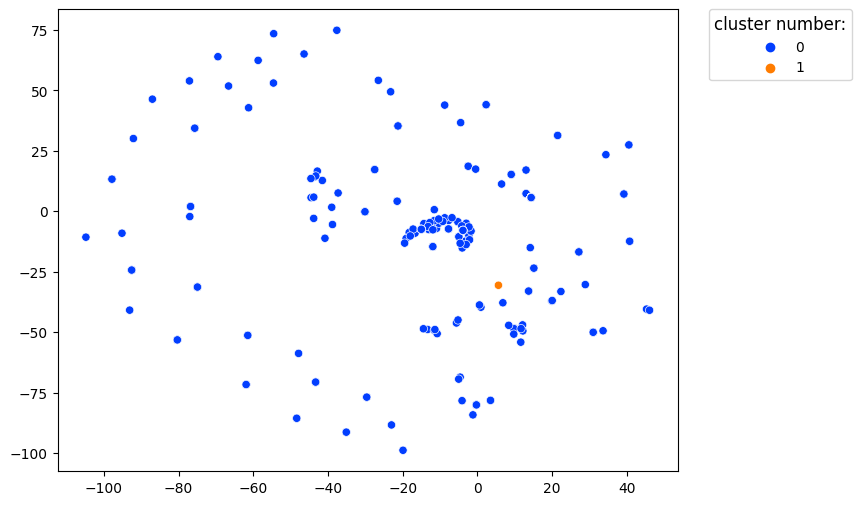

In [ ]:
from retentioneering.tooling.clusters import Clusters

clusters = Clusters(eventstream=pc_eventstream)
features = clusters.extract_features(ngram_range=(1, 2), feature_type='markov')
clusters.fit(method='kmeans', n_clusters=2, X=features, random_state=42)

clusters.projection(method='tsne')

In [ ]:
#Наиболее посещаемые страницы
page_visits_200 = df[df['status']==200]['request_path'].unique()
page_visits_counts_200 = df[df['status']==200]['request_path'].nunique()

page_visits_301 = df[df['status']==301]['request_path'].unique()
page_visits_counts_301 = df[df['status']==301]['request_path'].nunique()

print(page_visits_301)
print(page_visits_counts_301)

['/api.php?key=1&apikey=1' '/actuator/health' '/hosteng' ...
 'http://azenv.net/' '/adadaddadad' '/css/album.css']
12170


           body_bytes_sent http_referer  \
new_index                                 
1                      162          NaN   
3                      162          NaN   
4                      162          NaN   
5                      162          NaN   
6                      162          NaN   
...                    ...          ...   
200759                   0          NaN   
200760                 162          NaN   
200761                 162          NaN   
200762                 162          NaN   
200763                 162          NaN   

                                             http_user_agent      remote_addr  \
new_index                                                                       
1                                      Mozilla/5.0 zgrab/0.x  192.241.212.152   
3          Mozilla/5.0 (compatible; CensysInspect/1.1; +h...    167.94.146.57   
4          Mozilla/5.0 (X11; Linux x86_64; rv:103.0) Geck...    64.62.197.231   
5                                  

In [ ]:
#Определение местонахождения пользователей

# import requests

# def get_location_by_ip(ip_address, country_list):
#     # URL для запроса
#     api_key = "a7c341596a5ca580c3a5ceea3ac017dc"
#     url = f"http://api.ipstack.com/{ip_address}?access_key={api_key}"

#     try:
#         # Отправляем запрос и получаем ответ в формате JSON
#         response = requests.get(url)
#         data = response.json()

#         # Извлекаем интересующие нас данные о местоположении
# #         city = data.get('city', 'N/A')
#         country = data.get('country_name', 'N/A')

#         # Выводим информацию о местоположении
# #         print("Местоположение по IP:")
# #         print(f"Город: {city}")
# #         print('\n')

#         country_list.append(country)
# #         city_list.append(city)
#     except requests.exceptions.RequestException as e:
#         print("Произошла ошибка при запросе к API:", e)

# # Ваш API-ключ от ipstack

# country_list = []
# ip_addr_list = df['remote_addr'].unique().tolist()

# for i in ip_addr_list:
# # IP-адрес для запроса местоположения
#     ip_address = i

# # Получаем информацию о местоположении по IP
#     get_location_by_ip(ip_address, country_list)



In [ ]:

# print(country_list)

# from collections import Counter

# counter = Counter(country_list)

# plt.figure(figsize=(12, 7))
# plt.plot(counter.items(),counter.values(), marker='o')

# plt.ylabel('Количество')
# plt.xlabel('Страны')
# plt.title('Страны пользователей')
# plt.grid(which='both', linewidth=0.5)
# plt.show()


In [ ]:
# Зависимость body_bytes_sent от request_path